Description: co-dependance analysis between High Wind and Extremely low temperature.
We Use the Chi metric (Coles et al., 2000).
Where: Chi=P(Wind>alpha,-Temp>-alpha). We multiply the tempoerture vector by -1 as we are interested by extremely low temperature. NB: this is not exactly eq. to conditioning on T<alpha, as T not symmetric.

General Imports

In [186]:
# Imports
library("extRemes")
library(ncdf4)                  # needed to read netcdf data
library(ncdf4.helpers)          # additional support functions for netcdf data
library(fields)                 # provides image.plot()
library(rgdal)                  # load shapefiles
setwd("~/UKCP18/ukcp-other/extremal-dependence-data/")

In [187]:
# Land Sea Mask
nc_mask <- nc_open("land-sea_mask_uk_12km-rll.nc")
lsm <- ncvar_get(nc_mask)
nc_close(nc_mask); remove(nc_mask)

Global Variables

In [207]:
# Main Variable
# percentile level u s.t. Chi(u) = P(X>u/Y>u)

CHI_CUTOFF = 0.95

#startdate="20501201"
#enddate="20601130"

startdate="20201201"
enddate="20301130"

# Example Wind Farm coordinates
s_lon=54.00
s_lat=7.00


Helper-functions:

In [208]:
# Chi/Chibar calculation
get_chi_two_series <- function(x, y, t){
    return(taildep(x, y, CHI_CUTOFF, type = t))
}

# Map (lon,lat) to the grid indices
get_loc_lat_ids_from_coords <- function(lon, lat){
   
}
# convert from rotated to regular longitude & latitude
unrotate <- function (rlon.in, rlat.in) 
{
    # lat & lon of rotated pole
    plat = 39.25; plon = -162
    
    # convert to radians
    rlon <- rlon.in * pi/180
    rlat <- rlat.in * pi/180
    theta <- -(90 - plat) * pi/180
    phi <- -(180 + plon) * pi/180
    
    # convert to Cartesian coordinates
    x <- cos(rlon) * cos(rlat)
    y <- sin(rlon) * cos(rlat)
    z <- sin(rlat)
    
    # rotate Cartesian coordinates
    x_new = cos(theta) * cos(phi) * x + sin(phi) * y + sin(theta) * cos(phi) * z
    y_new = -cos(theta) * sin(phi) * x + cos(phi) * y - sin(theta) * sin(phi) * z
    z_new = -sin(theta) * x + cos(theta) * z
    
    # convert Cartesian coordinates back to lat & lon
    rlon_new = atan2(y_new, x_new) * 180/pi
    rlat_new = asin(z_new) * 180/pi
    
    return(c(rlon = rlon_new, rlat = rlat_new))
}
# convert from regular to rotated longitude & latitude
rotate <- function(lon.in, lat.in) {
    
    # lat & lon of rotated pole
    plat = 39.25; plon = -162
    
    # convert to radians
    lon <- lon.in * pi/180
    lat <- lat.in * pi/180
    theta <- (90 - plat) * pi/180
    phi <- (180 + plon) * pi/180
    
    # convert to Cartesian coordinates
    x <- cos(lon) * cos(lat)
    y <- sin(lon) * cos(lat)
    z <- sin(lat)
    
    # rotate Cartesian coordinates
    x_new = cos(theta) * cos(phi) * x + cos(theta) * sin(phi) * y + sin(theta) * z
    y_new = -sin(phi) * x + cos(phi) * y
    z_new = -sin(theta) * cos(phi) * x - sin(theta) * sin(phi) * y + cos(theta) * z
    
    # convert Cartesian coordinates back to lat & lon
    lon_new = atan2(y_new, x_new) * 180/pi
    lat_new = asin(z_new) * 180/pi
    
    return(c(lon = lon_new, lat = lat_new))
}

Loading Data

In [209]:
# Loading nc files

# Temp data
# Input Simulation Data

# temp_file<- "tasmax_rcp85_land-rcm_uk_12km-rll_01_day_20201201-20301130.nc"
#wind_file<- "sfcWindmax_rcp85_ukcp18_natgb_01_day_20201201-20301130.nc"
temp_file<- paste0("tasmax_rcp85_land-rcm_uk_12km-rll_01_day_",startdate,"-",enddate,".nc")
wind_file<- paste0("sfcWindmax_rcp85_ukcp18_natgb_01_day_",startdate,"-",enddate,".nc")

temp_file_base<- "tasmax_rcp85_land-rcm_uk_12km-rll_01_day_20101201-20201130.nc"
wind_file_base<- "sfcWindmax_rcp85_ukcp18_natgb_01_day_20101201-20201130.nc"


nc_temp <- nc_open(temp_file)
tasmax <- ncvar_get(nc_temp, "tasmax")
dimnames(tasmax) <- list("rlon" = ncvar_get(nc_temp, "grid_longitude") - 360,
                          "rlat" = ncvar_get(nc_temp, "grid_latitude"),
                          "date" = substr(nc.get.time.series(nc_temp, "tasmax"),1,10))

nc_lat_temp <- ncvar_get( nc_temp, attributes(nc_temp$dim)$names[2])
nc_long_temp <- ncvar_get( nc_temp, attributes(nc_temp$dim)$names[3])

time_temp <- nc.get.time.series(nc_temp, "tasmax")
nc_close(nc_temp); remove(nc_temp)
   

# temp data Base period
nc_temp_base <- nc_open(temp_file_base)
tasmax_base <- ncvar_get(nc_temp_base, "tasmax")
dimnames(tasmax_base) <- list("rlon" = ncvar_get(nc_temp_base, "grid_longitude") - 360,
                          "rlat" = ncvar_get(nc_temp_base, "grid_latitude"),
                          "date" = substr(nc.get.time.series(nc_temp_base, "tasmax"),1,10))
time_temp_base <- nc.get.time.series(nc_temp_base, "tasmax")
nc_close(nc_temp_base); remove(nc_temp_base)
# Wind data

nc_wind <- nc_open(wind_file)
windmax <- ncvar_get(nc_wind, "wind")
dimnames(windmax) <- list("rlon" = ncvar_get(nc_wind, "rlon") - 360,
                          "rlat" = ncvar_get(nc_wind, "rlat"),
                          "date" = substr(nc.get.time.series(nc_wind, "wind"),1,10))
time_wind <- nc.get.time.series(nc_wind, "wind")
nc_close(nc_wind); remove(nc_wind)


# temp data Base period
nc_wind_base <- nc_open(wind_file_base)
windmax_base <- ncvar_get(nc_wind_base, "wind")
dimnames(windmax_base) <- list("rlon" = ncvar_get(nc_wind_base, "rlon") - 360,
                          "rlat" = ncvar_get(nc_wind_base, "rlat"),
                          "date" = substr(nc.get.time.series(nc_wind_base, "wind"),1,10))
time_wind_base <- nc.get.time.series(nc_wind_base, "wind")
nc_close(nc_wind_base); remove(nc_wind_base)
#View(dim(tasmax))
#View(dim(windmax))


Main Computation

In [211]:
# Common Dates
common_dates<-intersect(time_temp,time_wind)
idx_wind<-which(time_wind %in% common_dates)
idx_temp<-which(time_temp %in% common_dates)


# Common Dates Ref Period
common_dates_base<-intersect(time_temp_base,time_wind_base)
idx_wind_base<-which(time_wind_base %in% common_dates_base)
idx_temp_base<-which(time_temp_base %in% common_dates_base)

# Grid dimensions
nlat<-dim(nc_lat_temp)
nlong<-dim(nc_long_temp)

# Approximating the Ref point coordinates on the grid using nearest point


v=rotate(s_lon,s_lat)
s_lon_ll=v[1]
s_lat_ll=v[2]
lat_ = which.min(abs(nc_lat_temp - s_lat_ll))
lon_ = which.min(abs(nc_long_temp - s_lon_ll))

x_ref=windmax[lon_,lat_,]
x_ref_base=windmax_base[lon_,lat_,]

# Chi calculation
chi_matrix = matrix(0, nlong, nlat)
chi_matrix_base= matrix(0, nlong, nlat)
chibar_matrix = matrix(0, nlong, nlat)
chibar_matrix_base= matrix(0, nlong, nlat)

# unrotate coordinates
nc_lat_temp_ll=nc_lat_temp
nc_long_temp_ll=nc_long_temp


for(i in 1:nlong){
    for (j in 1:nlat){
        # future
        chi_matrix[i,j] = get_chi_two_series(x_ref[idx_wind], -tasmax[i,j,idx_temp],"chi")
        chibar_matrix[i,j] = get_chi_two_series(x_ref[idx_wind], -tasmax[i,j,idx_temp],"chibar")
        # base
        chi_matrix_base[i,j] = get_chi_two_series(x_ref_base[idx_wind], -tasmax_base[i,j,idx_temp],"chi")
        chibar_matrix_base[i,j] = get_chi_two_series(x_ref_base[idx_wind], -tasmax_base[i,j,idx_temp],"chibar")
        
        # populate the vectors of unrotated coordinates
        v<-unrotate(nc_long_temp[i],nc_lat_temp[j])
        nc_long_temp_ll[j]=v[1]
        nc_lat_temp_ll[j]=v[2]
        
    }
    }
diff_chi_matrix<-chi_matrix-chi_matrix_base
diff_chibar_matrix<-chibar_matrix-chibar_matrix_base

write.table(chi_matrix, file = paste0("~/chi_matrix_", startdate, "_", enddate, ".txt"), row.names=FALSE, col.names=FALSE)
write.table(chi_matrix, file = paste0("~/chibar_matrix_", startdate, "_", enddate, ".txt"), row.names=FALSE, col.names=FALSE)
write.table(diff_chi_matrix, file = paste0("~/diff_chi_matrix_", startdate, "_", enddate, ".txt"), row.names=FALSE, col.names=FALSE)
write.table(diff_chibar_matrix, file = paste0("~/diff_chibar_matrix_", startdate, "_", enddate, ".txt"), row.names=FALSE, col.names=FALSE)
 

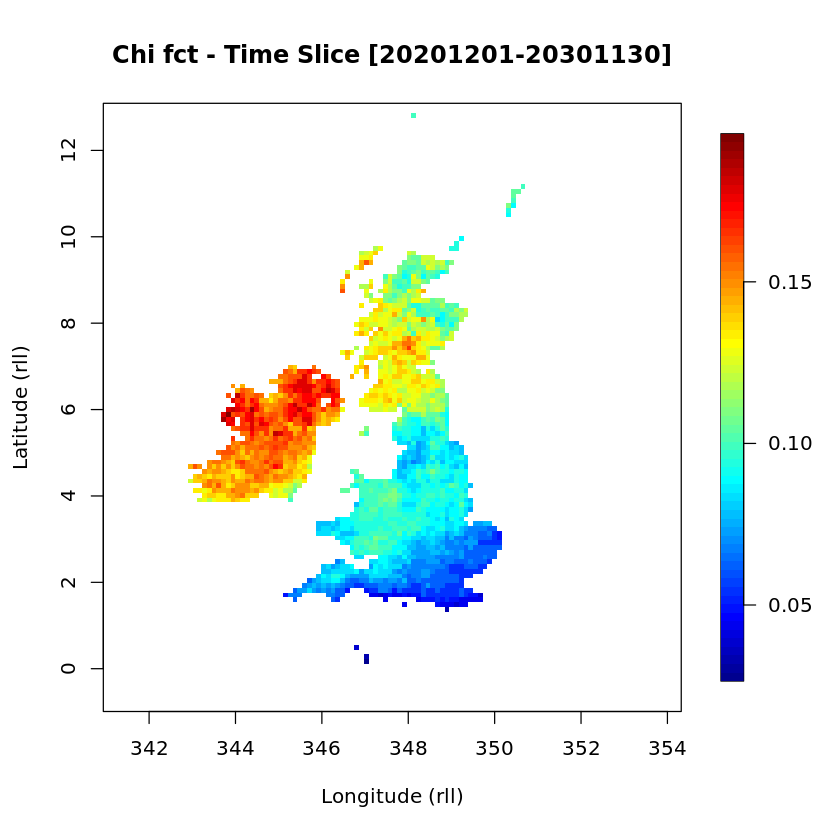

In [214]:
# Plot Chi 
osgbmap <- readOGR("ukcp18-uk-land-rll-united_kingdom-hires.geojson", verbose = F)
t<-paste("Chi fct - Time Slice [",startdate,"-",enddate,"]",sep="")
fnm<-paste("~/",t,".png",sep="")

#png(file=fnm,width=600, height=350)
image.plot(x = as.numeric(nc_long_temp), y = as.numeric(nc_lat_temp), chi_matrix*lsm, asp = T, 
           xlab = "Longitude (rll)", ylab = "Latitude (rll)", main = t)
# points(c(s_lon_ll), c(s_lat_ll),  pch=11, col = "black")
sp::plot(osgbmap, add = T)

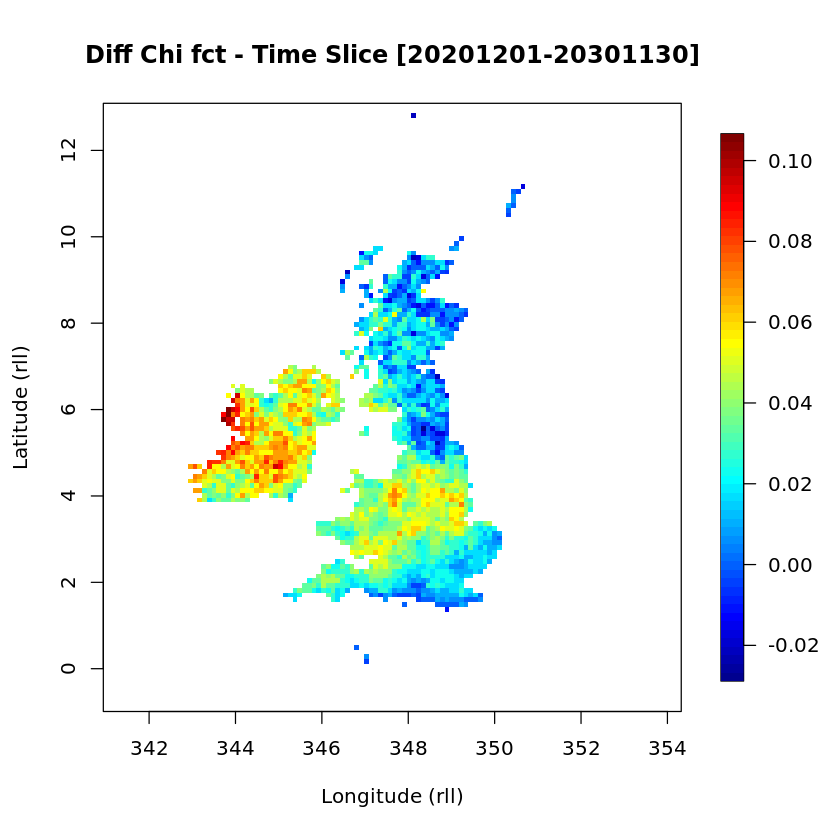

In [215]:
# Plot Diff Chi Fct
osgbmap <- readOGR("ukcp18-uk-land-rll-united_kingdom-hires.geojson", verbose = F)
t<-paste("Diff Chi fct - Time Slice [",startdate,"-",enddate,"]",sep="")
image.plot(x = as.numeric(nc_long_temp), y = as.numeric(nc_lat_temp), (diff_chi_matrix)*lsm, asp = T, 
           xlab = "Longitude (rll)", ylab = "Latitude (rll)", main = t)   
sp::plot(osgbmap, add = T)

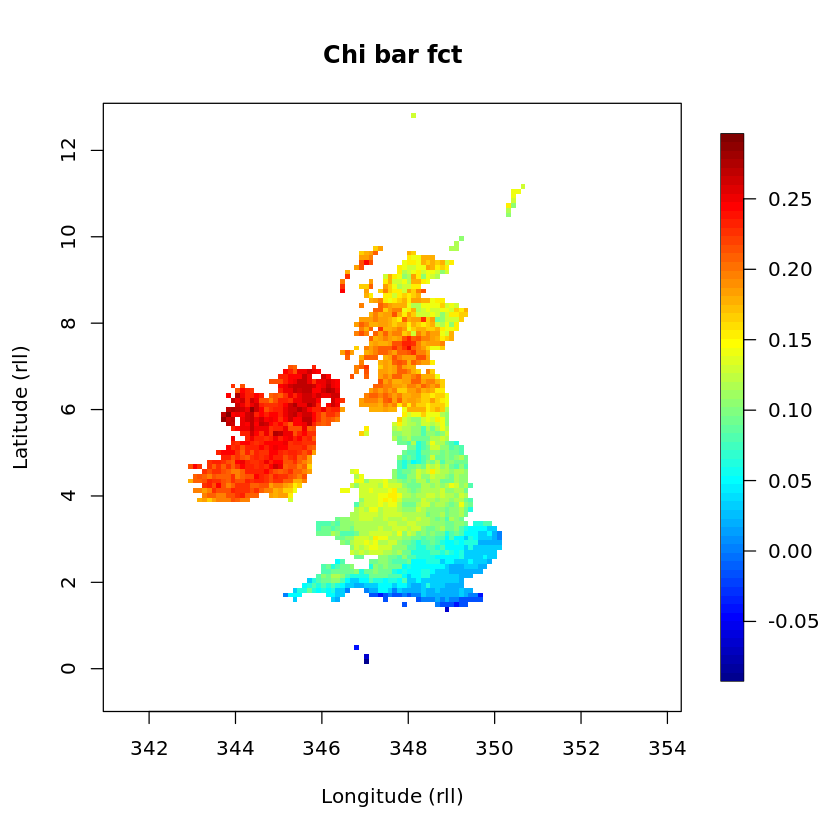

In [213]:
# Plot Chibar 
osgbmap <- readOGR("ukcp18-uk-land-rll-united_kingdom-hires.geojson", verbose = F)
t<-paste("Chibar fct - Time Slice [",startdate,"-",enddate,"]",sep="")
image.plot(x = as.numeric(nc_long_temp), y = as.numeric(nc_lat_temp), chibar_matrix*lsm, asp = T, 
           xlab = "Longitude (rll)", ylab = "Latitude (rll)", main = "Chi bar fct")   
sp::plot(osgbmap, add = T)

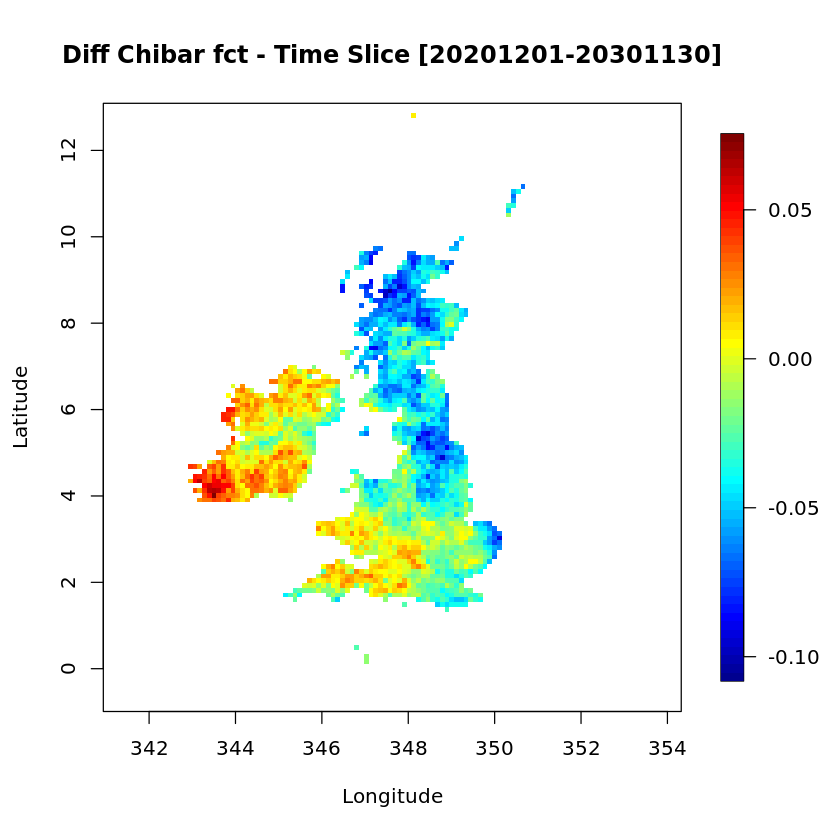

In [152]:
# Plot Diff Chibar
osgbmap <- readOGR("ukcp18-uk-land-rll-united_kingdom-hires.geojson", verbose = F)

t<-paste("Diff Chibar fct - Time Slice [",startdate,"-",enddate,"]",sep="")
image.plot(x = as.numeric(nc_long_temp), y = as.numeric(nc_lat_temp), (diff_chibar_matrix)*lsm, asp = T, 
           xlab = "Longitude (rll)", ylab = "Latitude (rll)", main = t)   
sp::plot(osgbmap, add = T)